In [1]:
import pandas as pd

import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [3]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.060351536580523

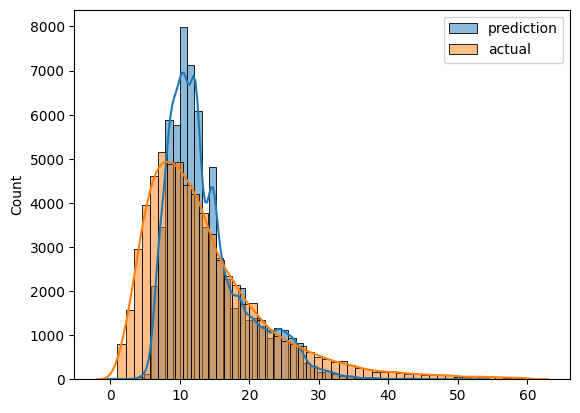

In [4]:
#sns.distplot(y_pred, label='prediction')
#sns.distplot(y_train, label='actual')
#plt.legend()

sns.histplot(y_pred, label='prediction', kde=True, 
              kde_kws=dict(cut=3), bins=50)
sns.histplot(y_train, label='actual', kde=True,
              kde_kws=dict(cut=3), bins=50)
plt.legend()
plt.show();

In [5]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [6]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet')
len(df_train), len(df_val)

(65946, 62574)

In [7]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [8]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=True)**0.5

print(rmse)

6.037803764245777


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [9]:
with open('models/linear_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [10]:
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/MLOps_zoomcamp/02-Experiment-tracking/mlruns/2', creation_time=1716846763721, experiment_id='2', last_update_time=1716846763721, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [11]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "olawale")
    
    mlflow.log_param("train-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet")
    mlflow.log_param("valid-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=True)**0.5
    mlflow.log_metric("rmse", rmse)
    
    mlflow.log_artifact(local_path="models/linear_reg.bin", artifact_path="models_pickle")

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
